In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

In [2]:
# get path from config.json
with open('config.json') as f:
    config = json.load(f)

# Define paths to the image and annotation folders
train_img_folder = config['train']['train_img_folder']
train_ann_folder = config['train']['train_ann_folder']

# Initialize lists to store images and annotations
train_images = []
train_annotations = []

In [3]:
class DatasetLoader:
    def __init__(self, img_folder, ann_folder):
        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.images = []
        self.annotations = []
    
    def load_dataset(self):
        # Iterate through each annotation file in the "ann" folder
        for ann_file in os.listdir(self.ann_folder):
            if ann_file.endswith('.json'):
                # Extract image filename from annotation filename
                img_filename = ann_file[:-5]  # Remove the last 5 characters (".json")

                # Load the corresponding image using PIL Image
                img_path = os.path.join(self.img_folder, img_filename)
                img = Image.open(img_path)
                
                # Load the annotation data from the JSON file
                with open(os.path.join(self.ann_folder, ann_file), 'r') as f: # r is for read
                    ann_data = json.load(f)
                
                # Extract bounding box coordinates and class labels
                boxes = []
                labels = []

                # for each object in the annotation file
                # extract the coordinates and classTitle
                for obj in ann_data['objects']:
                    xmin, ymin = obj['points']['exterior'][0] # bottom left corner
                    xmax, ymax = obj['points']['exterior'][1] # top right corner

                    # append the coordinates and classTitle to the boxes and labels lists
                    boxes.append([xmin, ymin, xmax, ymax]) 
                    labels.append(obj['classTitle'])
                
                # For every image, append image and annotations to the lists created in the __init__ method
                self.images.append(img) # in PIL Image format
                self.annotations.append({'boxes': boxes, 'labels': labels}) # in dictionary format

        # Display the number of images loaded
        print(f"Number of images loaded: {len(self.images)}")

    def show_image_with_boxes(self, idx=None):

        if idx is None:
            # Select a random image from the dataset
            # get a random index from the images list
            idx = random.randint(0, len(self.images) - 1) 
        img = self.images[idx]
        annotations = self.annotations[idx]
        
        # Plot the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        # Get the current Axes instance on the current figure 
        # gca stands for get current axis
        ax = plt.gca()
        # ax is used to add patches to the image (e.g. bounding boxes, labels, etc.)
        
        # Plot bounding boxes

        # for each box and label in the annotations dictionary
        for box, label in zip(annotations['boxes'], annotations['labels']):
            # unpack the box coordinates
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            # create a Rectangle patch using matplotlib.patches
            rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
            # add the rectangle to the Axes instance
            ax.add_patch(rect)
            # add a label to the rectangle
            plt.text(xmin, ymin, label, fontsize=10, color='r', verticalalignment='top', backgroundcolor='blue')
            #plt.text(xmin + 0.5 * width, ymin - 3, label, fontsize=10, color='r', ha='right', backgroundcolor='white')
        
        plt.axis('off')
        plt.show()

In [4]:
# train set loader
train_loader = DatasetLoader(train_img_folder, train_ann_folder)
train_loader.load_dataset()

Number of images loaded: 2246


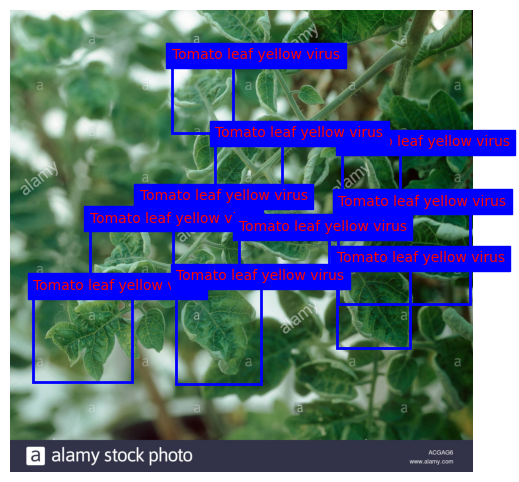

In [5]:
# show random image with bounding boxes
train_loader.show_image_with_boxes()